In [1]:
import re
import os
import sys
import h5py
import time
import numpy as np
import scipy as sp
from utils import *
import mindspore as ms
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindspore.common.initializer import *
from mindquantum.simulator import Simulator
from mindquantum.algorithm.compiler import *
from scipy.linalg import expm, sqrtm, block_diag
from numpy.linalg import det, svd, eigh, norm, matrix_rank

np.set_printoptions(linewidth=200)

In [2]:
d = 3
nq = d - 1
for i in range(2**nq):
    for j in range(2**nq):
        a = 'aij|x⟩⟨y|'.replace('i', str(i)).replace('j', str(j))
        a = a.replace('x', bin(i)[2:].zfill(nq)).replace('y', bin(j)[2:].zfill(nq))
        print(a, end=' ')
    print()

a00|00⟩⟨00| a01|00⟩⟨01| a02|00⟩⟨10| a03|00⟩⟨11| 
a10|01⟩⟨00| a11|01⟩⟨01| a12|01⟩⟨10| a13|01⟩⟨11| 
a20|10⟩⟨00| a21|10⟩⟨01| a22|10⟩⟨10| a23|10⟩⟨11| 
a30|11⟩⟨00| a31|11⟩⟨01| a32|11⟩⟨10| a33|11⟩⟨11| 


In [3]:
d = 3
n = 2**(d - 1)
a1 = unitary_group.rvs(d)
a2 = su2_encoding(a1)
print(a1)
print(a2)
p = np.eye(n) - su2_encoding(np.eye(d))
print(p)
a2 += p
is_unitary(a2), is_symmetric(a2)

[[ 0.08516211-0.44598598j -0.61150151+0.51026305j -0.34994812+0.19255586j]
 [-0.07625552-0.78463319j  0.40702641-0.27245883j -0.26884638-0.25759109j]
 [ 0.09643167+0.40383252j  0.31396014+0.16499166j -0.83519723-0.06536507j]]
[[ 0.08516211-0.44598598j -0.43239686+0.36081046j -0.43239686+0.36081046j -0.34994812+0.19255586j]
 [-0.0539208 -0.55481945j  0.2035132 -0.13622941j  0.2035132 -0.13622941j -0.1901031 -0.1821444j ]
 [-0.0539208 -0.55481945j  0.2035132 -0.13622941j  0.2035132 -0.13622941j -0.1901031 -0.1821444j ]
 [ 0.09643167+0.40383252j  0.22200335+0.11666672j  0.22200335+0.11666672j -0.83519723-0.06536507j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, False)

In [4]:
# Test whether a qudit encoding is in the symmetric subspace
d = 3
i1 = np.eye(d)
a1 = unitary_group.rvs(d)
# a1 = np.reshape(range(d**2), [d, d])
i2 = su2_encoding(i1)
a2 = su2_encoding(a1)
print(a1)
print(a2)
is_symmetric(a2), matrix_rank(i2)

[[ 0.05707486-0.04881935j -0.14048988+0.08320474j -0.96816631-0.17422026j]
 [-0.59616925-0.65657795j -0.38694502-0.25046337j  0.03141996+0.00648497j]
 [-0.39792671+0.2224884j   0.61898477-0.61460481j -0.17681718-0.00277832j]]
[[ 0.05707486-0.04881935j -0.09934134+0.05883463j -0.09934134+0.05883463j -0.96816631-0.17422026j]
 [-0.42155532-0.46427072j -0.19347251-0.12523168j -0.19347251-0.12523168j  0.02221726+0.00458557j]
 [-0.42155532-0.46427072j -0.19347251-0.12523168j -0.19347251-0.12523168j  0.02221726+0.00458557j]
 [-0.39792671+0.2224884j   0.43768833-0.43459123j  0.43768833-0.43459123j -0.17681718-0.00277832j]]


(True, 3)

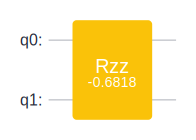

(True, True, True)

In [5]:
# U2⊗U2 Rxx Ryy Rzz SWAP preserve symmetry
d = 3
a1 = unitary_group.rvs(d)
b1 = np.random.rand(d) + 1j * np.random.rand(d)
b1 /= norm(b1)
a2 = su2_encoding(a1)
b2 = su2_encoding(b1)
# print(a1)
# print(a2)
# print(b1)
# print(b2)
t = np.random.uniform(-np.pi, np.pi)
k = Circuit() + Rzz(t).on([0, 1])
# k = Circuit() + UN(UnivMathGate('', unitary_group.rvs(2)), 2)
display_svg(k.svg())
k = k.matrix()
# print(k)
# print(a2 @ k)
# print(k @ a2)
# print(k @ b2)
is_symmetric(a2 @ k), is_symmetric(k @ a2), is_symmetric(k @ b2)

In [6]:
# How to restore a reduce density matrix
np.random.seed(42)
a = np.random.rand(2) + 1j * np.random.rand(2)
b = np.random.rand(2) + 1j * np.random.rand(2)
a /= norm(a)
b /= norm(b)
psi_ab = np.kron(a, b)
rho_a = np.outer(a, a.conj())
rho_b = np.outer(b, b.conj())
rho_ab = np.kron(rho_a, rho_b)
print(rho_a)
print(rho_b)
print(rho_ab)
print(psi_ab.conj() @ rho_ab @ psi_ab)
fidelity(rho_ab, psi_ab)

[[0.34880034+0.j         0.40977999+0.24334959j]
 [0.40977999-0.24334959j 0.65119966+0.j        ]]
[[0.03454462+0.j         0.0930421 -0.15714469j]
 [0.0930421 +0.15714469j 0.96545538+0.j        ]]
[[ 1.20491735e-02+0.j          3.24531155e-02-0.05481212j  1.41556919e-02+0.00840642j  7.63678855e-02-0.04175299j]
 [ 3.24531155e-02+0.05481212j  3.36751167e-01+0.j         -1.14305675e-04+0.0870365j   3.95624296e-01+0.23494318j]
 [ 1.41556919e-02-0.00840642j -1.14305675e-04-0.0870365j   2.24954416e-02+0.j          6.05889828e-02-0.10233257j]
 [ 7.63678855e-02+0.04175299j  3.95624296e-01-0.23494318j  6.05889828e-02+0.10233257j  6.28704218e-01+0.j        ]]
(1.0000000000000007+0j)


1.0000000000000002